# 교통 표지판 이미지 분류

Kaggle의 [gtsrb-german-traffic-sign](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) 데이터를 통해 교통 표지판 이미지 데이터를 분석하고 딥러딩 모델을 통하여 표지판 종류를 예측하는 분류 모델 수행한다.

이를 통해 대량의 이미지 데이터를 전처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습할 수 있다.

---

## 0. Library 불러오기

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential


%matplotlib inline

## 1. 데이터 분석

In [2]:
# data 확인
file_list = os.listdir('./data')
file_list

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

In [3]:
# Meta.csv
import pandas as pd

df_Meta = pd.read_csv('./data/Meta.csv')
df_Meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/0.png,0,1,0,3.29
1,Meta/1.png,1,1,0,3.29
2,Meta/2.png,2,1,0,3.29


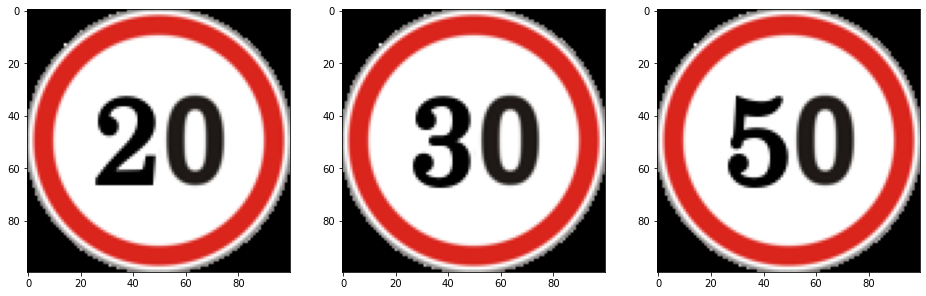

In [4]:
# 이미지 출력
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df_Meta)):
    img = load_img('./data/' + df_Meta['Path'][i])
    plt.subplot(1, 3, i+1) # 이미지 3개 출력
    plt.imshow(img)
    Meta_images.append(img)
    Meta_labels.append(df_Meta['ClassId'][i]) # labels 저장

In [5]:
# Train.csv
df_Train = pd.read_csv('./data/Train.csv')
df_Train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png


In [6]:
df_Train.shape # 일부 데이터만 사용

(2670, 8)

`Width`와 `Height` 이미지의 폭과 높이에 대한 정보로 이미지 크기를 통일해줄 필요가 있다.

우선 이미지 크기의 분포를 살펴보자

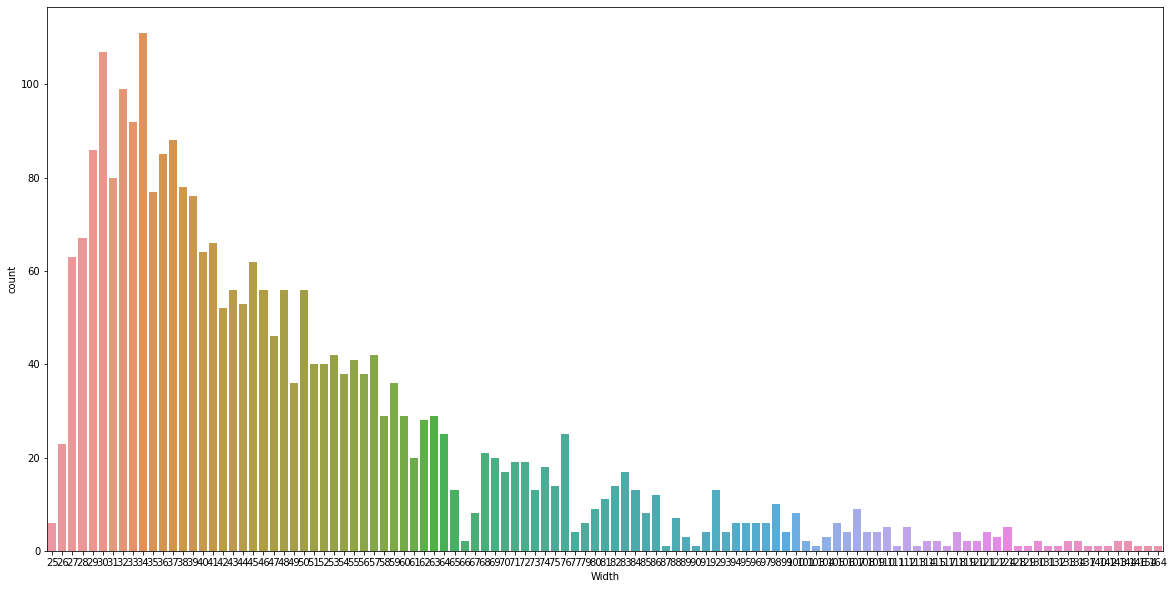

In [7]:
# Seaborn 사용
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width", data=df_Train)

ㅇㅇ

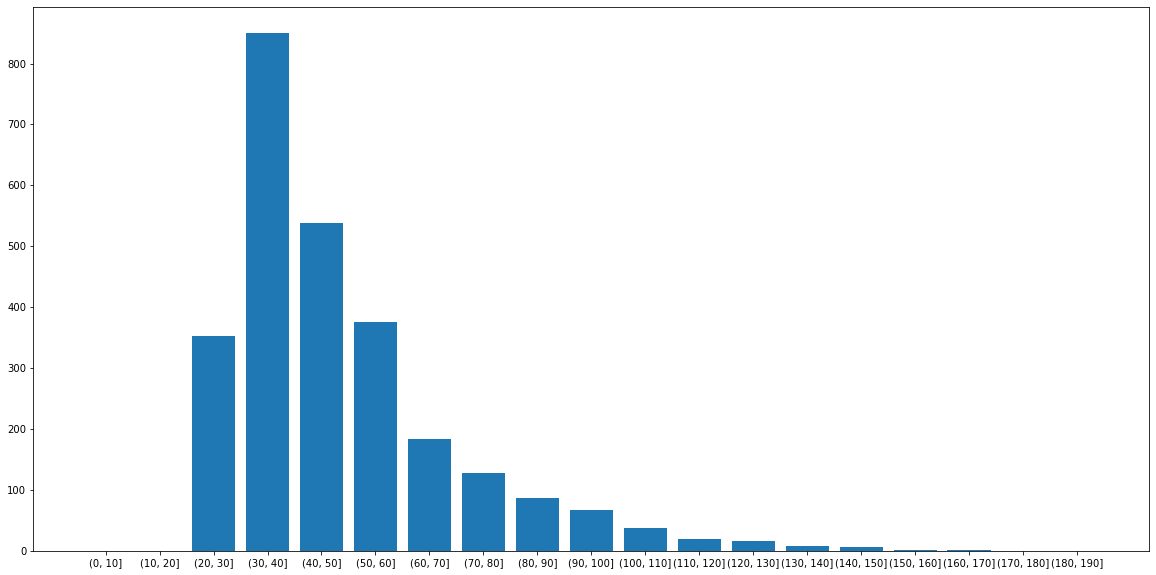

In [8]:
# matplotlib 사용
df_cutWidth = pd.cut(df_Train['Width'], np.arange(0,200,10)).value_counts(sort=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)), df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

이미지 크기를 통일하는 데 있어서 너무 작은 이미지는 큰 이미지의 정보 손실을 발생하며, 너무 큰 이미지는 작은 이미지의 정보 부족한 정보량을 부각할 수 있다.
이번 프로젝트에서는 이미지 분포 기반으로 대다수를 차지하는 크기인 33x33 크기로 통일해보자.

In [9]:
image_height = 33
image_width = 33
image_channel = 3 # 컬러 이미지이기에 3채널

Roi 데이터를 사용하면 보다 명확하게 표지판 부분만을 crop 할 수 있어 분류의 성능을 높일 수 있다.

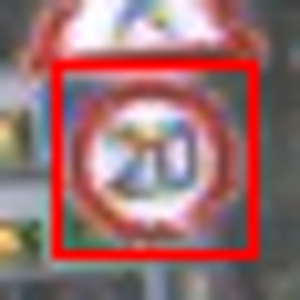

In [49]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('./data/' + df_Train['Path'][0])

draw = ImageDraw.Draw(img_sample)
draw.rectangle([df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]], outline="red")
img_sample_resized = img_sample.resize((300,300))
img_sample_resized

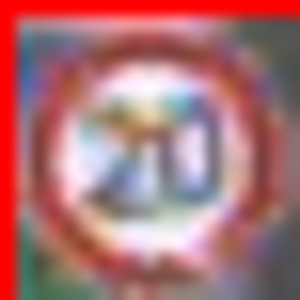

In [50]:
img_sample_crop = img_sample.crop((df_Train['Roi.X1'][0], df_Train['Roi.Y1'][0], df_Train['Roi.X2'][0], df_Train['Roi.Y2'][0]))

# Shows the image in image viewer
img_sample_crop_resized = img_sample_crop.resize((300,300))
img_sample_crop_resized

In [12]:
# Test.csv
df_Test = pd.read_csv('./data/Test.csv')
df_Test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,42,45,5,5,36,40,1,Test/00001.png
1,59,65,5,6,54,60,1,Test/00024.png
2,58,59,6,6,53,54,2,Test/00034.png
3,37,37,5,6,31,32,2,Test/00067.png
4,45,51,6,6,40,46,1,Test/00076.png


In [13]:
df_Test['ClassId'].value_counts()
# 원본 데이터의 class는 43개이지만 분류 모델을 만들기 위한 학습 과정이므로 우선 3개만 사용

1    336
2    326
0     38
Name: ClassId, dtype: int64

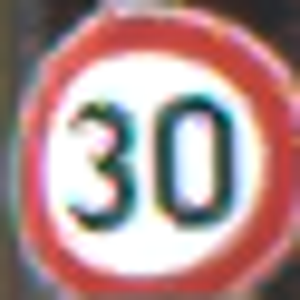

In [14]:
img_sample = Image.open('./data/' + df_Test['Path'][0])
img_sample_crop = img_sample.crop((df_Test['Roi.X1'][0], df_Test['Roi.Y1'][0], df_Test['Roi.X2'][0], df_Test['Roi.Y2'][0]))

# Shows the image in image viewer
img_sample_crop_resized = img_sample_crop.resize((300,300))
img_sample_crop_resized

## 2. 데이터 전 처리

In [95]:
# Train 이미지 crop 후 array 형태로 저장

image_height = 33
image_width = 33
image_channel = 3

Train_images = []
Train_labels = []

for i in tqdm(range(len(df_Train))):
    img = load_img('./data/'+df_Train['Path'][i])
    img_crop = img.crop((df_Train['Roi.X1'][i], df_Train['Roi.Y1'][i], df_Train['Roi.X2'][i], df_Train['Roi.Y2'][i]))
    img_crop = img_crop.resize((image_height, image_width))
    img_result = img_to_array(img_crop)
    Train_images.append(img_result)

100%|██████████| 2670/2670 [01:21<00:00, 32.95it/s]


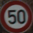

In [82]:
img_crop

In [96]:
len(Train_images)

2670

In [117]:
# Test 이미지 crop 후 array 형태로 저장

Test_images = []
Test_labels = []

for i in tqdm(range(len(df_Test))):
    img = load_img('./data/'+df_Test['Path'][i])
    img_crop = img.crop((df_Test['Roi.X1'][i], df_Test['Roi.Y1'][i], df_Test['Roi.X2'][i], df_Test['Roi.Y2'][i]))
    img_crop = img_crop.resize((image_height, image_width))
    img_result = img_to_array(img_crop)
    Test_images.append(img_result)

100%|██████████| 700/700 [00:19<00:00, 36.84it/s]


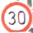

In [84]:
img_crop

In [98]:
Train_labels = df_Train['ClassId'].values
Train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [122]:
Test_labels = df_Test['ClassId'].values
Test_labels

array([1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
       0, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,

In [99]:
x_train, x_val, y_train, y_val = train_test_split(np.array(Train_images), np.array(Train_labels), test_size=0.4)

In [123]:
x_test = np.array(Test_images)
y_test = np.array(Test_labels)

## 3. 딥러닝 모델

### CNN 

In [101]:
model = Sequential([    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(image_height, image_width, image_channel)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.25),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [102]:
# 학습 수행
model.compile(
    loss='sparse_categorical_crossentropy', # 3개의 class
    optimizer='adam',
    metrics=['accuracy']
)

In [103]:
EPOCHS = 30

# EPOCHS에 따른 성능을 보기 위하여 history 사용
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_val, y_val), # validation 데이터 사용
                    epochs=EPOCHS, 
                   )

Epoch 1/30
51/51 [==============================] - 3s 43ms/step - loss: 85.3168 - accuracy: 0.4529 - val_loss: 1.0766 - val_accuracy: 0.4551
Epoch 2/30
51/51 [==============================] - 2s 42ms/step - loss: 1.0156 - accuracy: 0.4849 - val_loss: 0.9797 - val_accuracy: 0.4579
Epoch 3/30
51/51 [==============================] - 2s 42ms/step - loss: 0.9566 - accuracy: 0.4668 - val_loss: 0.9326 - val_accuracy: 0.4579
Epoch 4/30
51/51 [==============================] - 2s 42ms/step - loss: 0.9282 - accuracy: 0.5104 - val_loss: 0.9229 - val_accuracy: 0.4607
Epoch 5/30
51/51 [==============================] - 2s 40ms/step - loss: 0.9275 - accuracy: 0.4841 - val_loss: 0.9208 - val_accuracy: 0.4625
Epoch 6/30
51/51 [==============================] - 2s 40ms/step - loss: 0.9186 - accuracy: 0.4704 - val_loss: 0.9193 - val_accuracy: 0.4644
Epoch 7/30
51/51 [==============================] - 2s 41ms/step - loss: 0.9335 - accuracy: 0.4913 - val_loss: 0.9186 - val_accuracy: 0.4672
Epoch 8/30
5

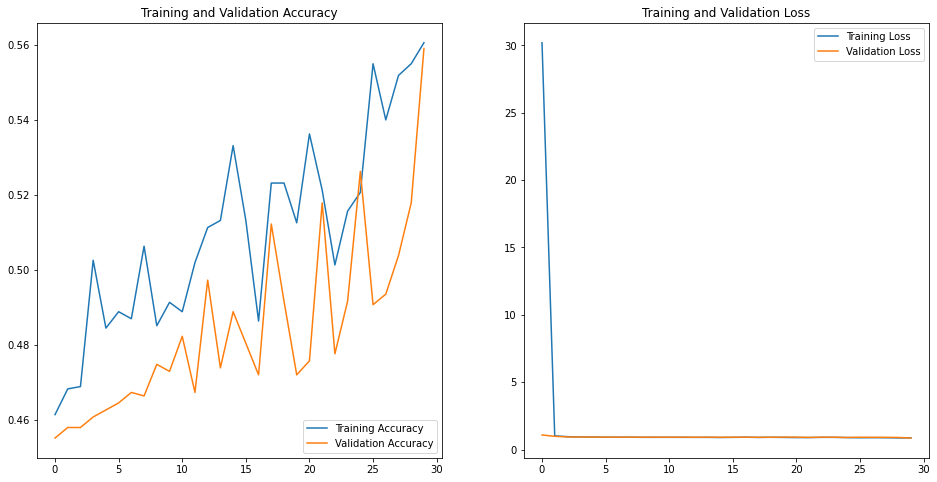

In [119]:
# Accuracy와 Loss의 변화를 그래프로 출력

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [124]:
# 모델 성능 평가 및 예측

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('test set accuracy: ', test_accuracy)

test set accuracy:  0.48571428656578064


In [125]:
test_prediction = np.argmax(model.predict(x_test), axis=-1)

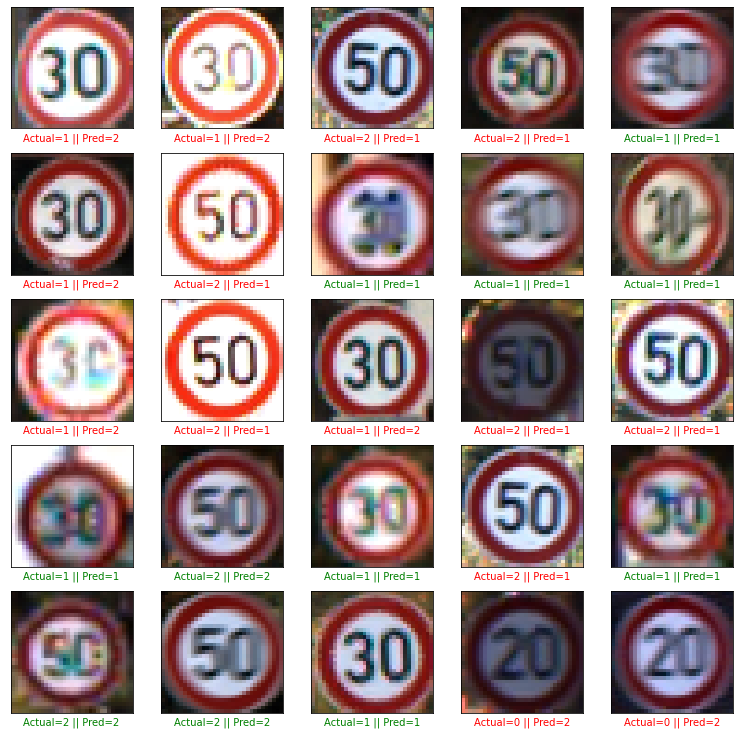

In [126]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = test_prediction[start_index + i]
    actual = y_test[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(array_to_img(x_test[start_index + i]))
plt.show()

<AxesSubplot:>

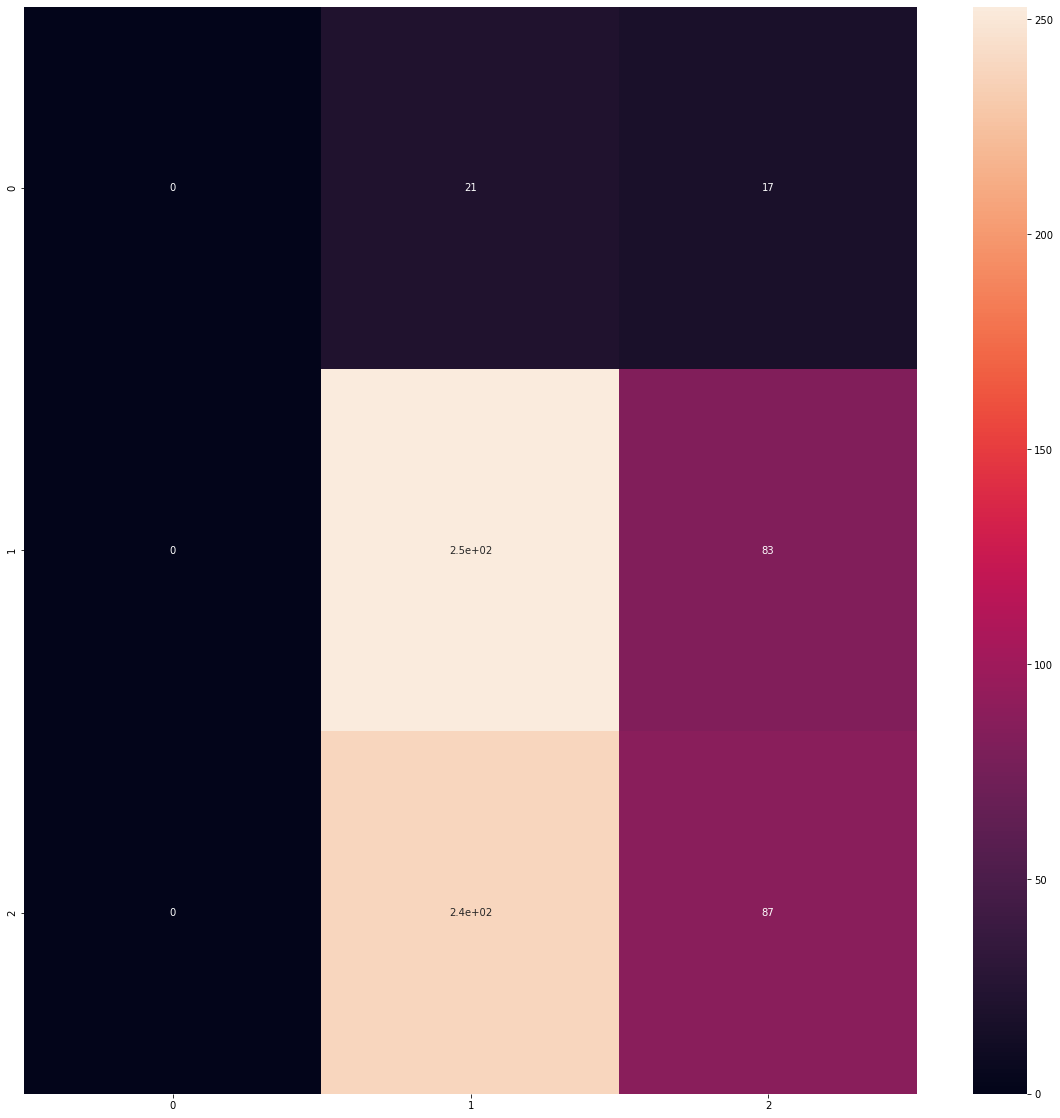

In [127]:
# confusion matrix 시각화

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)
plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True)

In [128]:
# x_train, y_train의 confusion matrix
train_prediction = np.argmax(model.predict(x_train), axis=-1)
cm_train = confusion_matrix(y_train, train_prediction)
cm_train

array([[  0, 118,   4],
       [  0, 627, 112],
       [  0, 429, 312]])

---

분류 모델 학습 과정을 위해 3개의 label에 대해서만 학습을 수행했지만 원본 데이터에서는 43개의 label로 이루어져 있다.
따라서 43개의 label 모두에 대한 분류 모델을 만들기 위해 전처리 단계에서 Data augmentation을 통해서 데이터의 수를 늘리는 방법 사용해보자
또한 CNN 모델 외 VGG, GoogLeNet, ResNet 등을 사용하여 성능을 높여보자.